In [6]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext


In [7]:
# Edit based on job info
sc = SparkSession.builder \
    .config("spark.driver.memory", "4g") \
	.config("spark.executor.memory", "20g") \
    .config('spark.executor.instances', 9) \
	.appName("Word2Vec") \
	.getOrCreate()
spark = sc  
sc = spark.sparkContext 

In [40]:
from pyspark.sql.functions import col, regexp_extract, from_unixtime, col, year, month, quarter, avg, count, when, sum, length
from pyspark.sql import functions as F
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def get_shape(df):
    return (df.count(), len(df.columns))

In [10]:
base_dir = "/expanse/lustre/projects/uci150/anguyen17/spark_notebooks/Amazon Review Project"
essential_files = []
luxury_files = []

# Find files
for pos_json in os.listdir(base_dir):
    if pos_json.endswith('.jsonl'):
        full_path = os.path.join(base_dir, pos_json)
        if "Grocery" in pos_json or "Baby" in pos_json:
            essential_files.append(full_path)
        elif "Movies" in pos_json or "Video" in pos_json:
            luxury_files.append(full_path)
            
# Essential data
if essential_files:
    essential_df = spark.read.json(essential_files)
    essential_df = essential_df.withColumn("product_group", F.lit("essential"))
    essential_rows, essential_cols = get_shape(essential_df)
    print(f"Essential DataFrame shape: ({essential_rows}, {essential_cols})")
else:
    print("No essential product files found")
    essential_df = None
    
# Luxury data
if luxury_files:
    luxury_df = spark.read.json(luxury_files)
    luxury_df = luxury_df.withColumn("product_group", F.lit("luxury"))
    luxury_rows, luxury_cols = get_shape(luxury_df)
    print(f"Luxury DataFrame shape: ({luxury_rows}, {luxury_cols})")
else:
    print("No luxury product files found")
    luxury_df = None

# Merged data
if essential_df is not None and luxury_df is not None:
    merged_df = essential_df.union(luxury_df)
    merged_rows, merged_cols = get_shape(merged_df)
    print(f"Merged DataFrame shape: ({merged_rows}, {merged_cols})")
else:
    print("No files were found and loaded.")
    merged_df = None

Essential DataFrame shape: (20347404, 11)
Luxury DataFrame shape: (21952929, 11)
Merged DataFrame shape: (42300333, 11)


In [11]:
merged_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- product_group: string (nullable = false)



In [17]:
nulls = merged_df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
                          for c in merged_df.columns])
nulls.show()

+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|product_group|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|            0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+-------------+



In [18]:
# Filter out review that refers to images 
def filter_non_image_text(df, name):
    filtered_df = df.filter(
        col("text").isNotNull() &
        ~(col("text").rlike(r"^\s*(\[image\]|\(image\)|image only|just a picture|no text)") | col("text").rlike(r"^\s*$") |  
          (col("images").isNotNull() & col("text").rlike(r"^\s*[0-9]+\s*$")))) 
    
    original_count = df.count()
    filtered_count = filtered_df.count()
    print(f"{name} - Original row count: {original_count}")
    print(f"{name} - Filtered row count: {filtered_count}")
    
    return filtered_df

dataframes_to_process = [(essential_df, "Essential"),(luxury_df, "Luxury"),(merged_df, "Merged")]
cleaned_df = {}
for df, name in dataframes_to_process:
        cleaned_df[name.lower()] = filter_non_image_text(df, name)


Essential - Original row count: 20347404
Essential - Filtered row count: 20323459
Luxury - Original row count: 21952929
Luxury - Filtered row count: 21946745
Merged - Original row count: 42300333
Merged - Filtered row count: 42270204


In [38]:
cleaned_df["merged"] = cleaned_df["merged"].withColumn("text_len", length("text"))
cleaned_df["merged"].select("text_len").describe().show()

+-------+------------------+
|summary|          text_len|
+-------+------------------+
|  count|          42270204|
|   mean|212.53295718657995|
| stddev|442.69071854238047|
|    min|                 1|
|    max|             36893|
+-------+------------------+



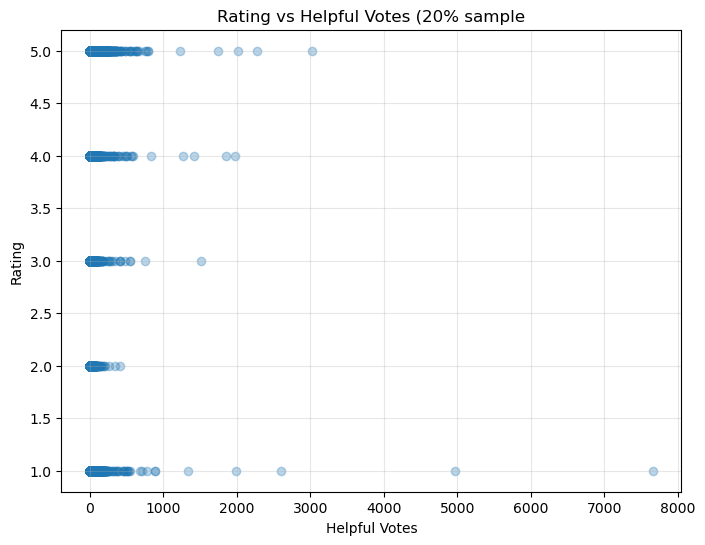

In [47]:
# Sample the data & plot helpful votes
rdd = cleaned_df["merged"].select("helpful_vote", "rating").sample(0.02, seed=42).rdd.map(lambda r: (r["helpful_vote"], r["rating"]))

data = rdd.collect()
helpful_votes, ratings = zip(*data)

plt.figure(figsize=(8, 6))
plt.scatter(helpful_votes, ratings, alpha=0.3)
plt.xlabel("Helpful Votes")
plt.ylabel("Rating")
plt.title("Rating vs Helpful Votes (20% sample")
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Convert time & only keep relevant columns
def prepare_df_for_analysis(df, name):
        analysis_df = df.withColumn("parsed_time", from_unixtime(col("timestamp")/1000)).withColumn(
            "year", year(col("parsed_time"))).select("asin", "text", "rating", "year", "product_group")

        print(f"\n{name} DataFrame:")
        analysis_df.show(3)
        
        return analysis_df

analysis_df = {}
for name, df in cleaned_df.items():
    analysis_df[name] = prepare_df_for_analysis(df, name.capitalize())
    


Essential DataFrame:
+----------+--------------------+------+----+-------------+
|      asin|                text|rating|year|product_group|
+----------+--------------------+------+----+-------------+
|B00CM36GAQ|Excellent!! Yummy...|   5.0|2020|    essential|
|B074J5WVYH|Excellent!  The b...|   5.0|2020|    essential|
|B079TRNVHX|These are very ta...|   5.0|2020|    essential|
+----------+--------------------+------+----+-------------+
only showing top 3 rows


Luxury DataFrame:
+----------+--------------------+------+----+-------------+
|      asin|                text|rating|year|product_group|
+----------+--------------------+------+----+-------------+
|B07DJWBYKP|I’m playing on ps...|   4.0|2020|       luxury|
|B00ZS80PC2|Nostalgic fun.  A...|   5.0|2020|       luxury|
|B01FEHJYUU|This was an order...|   5.0|2017|       luxury|
+----------+--------------------+------+----+-------------+
only showing top 3 rows


Merged DataFrame:
+----------+--------------------+------+----+-----

In [21]:
print("\nOverall average rating by product group:")
analysis_df['merged'].groupBy("product_group").agg(avg("rating").alias("avg_rating"),
                                                       count("rating").alias("count")).show()


Overall average rating by product group:
+-------------+-----------------+--------+
|product_group|       avg_rating|   count|
+-------------+-----------------+--------+
|    essential|4.149866860754362|20323459|
|       luxury|4.204117330383162|21946745|
+-------------+-----------------+--------+



In [22]:
def analyze_ratings_by_year(df, name):
    rating_counts_by_year = df.groupBy("year", "rating").count().orderBy("year", "rating")
    print(f"\n{name} - Rating counts by year and rating:")
    rating_counts_by_year.show(3)
    
    rating_pivot = df.groupBy("year").pivot("rating", [1.0, 2.0, 3.0, 4.0, 5.0]).count().fillna(0).orderBy("year")
    print(f"\n{name} - Rating pivot table:")
    rating_pivot.show(3)
    
    # Convert to RDD for plots
    rating_count_rdd = rating_pivot.select("year", "`1.0`", "`2.0`", "`3.0`", "`4.0`", "`5.0`").rdd.map(
        lambda r: (r["year"], r["1.0"] or 0, r["2.0"] or 0, r["3.0"] or 0, r["4.0"] or 0, r["5.0"] or 0))
    data = rating_count_rdd.collect()
    
    if data:
        years, one_star, two_star, three_star, four_star, five_star = zip(*data)
        print(f"\n Years analyzed: {list(years)}")
        
        return rating_pivot, data

results = {}
for name, df in analysis_df.items():
    pivot_table, rating_data = analyze_ratings_by_year(df, name.capitalize())
    results[name] = {'pivot_table': pivot_table,'rating_data': rating_data}


Essential - Rating counts by year and rating:
+----+------+-----+
|year|rating|count|
+----+------+-----+
|2000|   3.0|    1|
|2000|   4.0|    5|
|2000|   5.0|    8|
+----+------+-----+
only showing top 3 rows


Essential - Rating pivot table:
+----+---+---+---+---+---+
|year|1.0|2.0|3.0|4.0|5.0|
+----+---+---+---+---+---+
|2000|  0|  0|  1|  5|  8|
|2001| 28| 16| 19| 36|117|
|2002|161| 85| 94|199|481|
+----+---+---+---+---+---+
only showing top 3 rows


 Years analyzed: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Luxury - Rating counts by year and rating:
+----+------+-----+
|year|rating|count|
+----+------+-----+
|1997|   2.0|    1|
|1997|   3.0|    1|
|1997|   4.0|    4|
+----+------+-----+
only showing top 3 rows


Luxury - Rating pivot table:
+----+----+---+----+----+-----+
|year| 1.0|2.0| 3.0| 4.0|  5.0|
+----+----+---+----+----+-----+
|1997|   0|  1|   1|   4|   27|
|1998|  62|

In [23]:
# Average ratings for products by years

essential_avg = analysis_df['essential'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nEssential Products - Average rating by year:")
essential_avg.show(5)

luxury_avg = analysis_df['luxury'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nLuxury Products - Average rating by year:")
luxury_avg.show(5)

merged_avg = analysis_df['merged'].groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year")
print("\nMerged Products - Average rating by year:")
merged_avg.show(5)


Essential Products - Average rating by year:
+----+------------------+
|year|        avg_rating|
+----+------------------+
|2000|               4.5|
|2001|3.9166666666666665|
|2002|  3.73921568627451|
|2003| 3.937731196054254|
|2004|3.8281951511523498|
+----+------------------+
only showing top 5 rows


Luxury Products - Average rating by year:
+----+------------------+
|year|        avg_rating|
+----+------------------+
|1997|4.7272727272727275|
|1998| 4.410774410774411|
|1999| 4.258238316000501|
|2000| 4.129080568382392|
|2001| 4.064969257449157|
+----+------------------+
only showing top 5 rows


Merged Products - Average rating by year:
+----+------------------+
|year|        avg_rating|
+----+------------------+
|1997|4.7272727272727275|
|1998| 4.410774410774411|
|1999| 4.258238316000501|
|2000|4.1291731279967205|
|2001| 4.064465952298652|
+----+------------------+
only showing top 5 rows



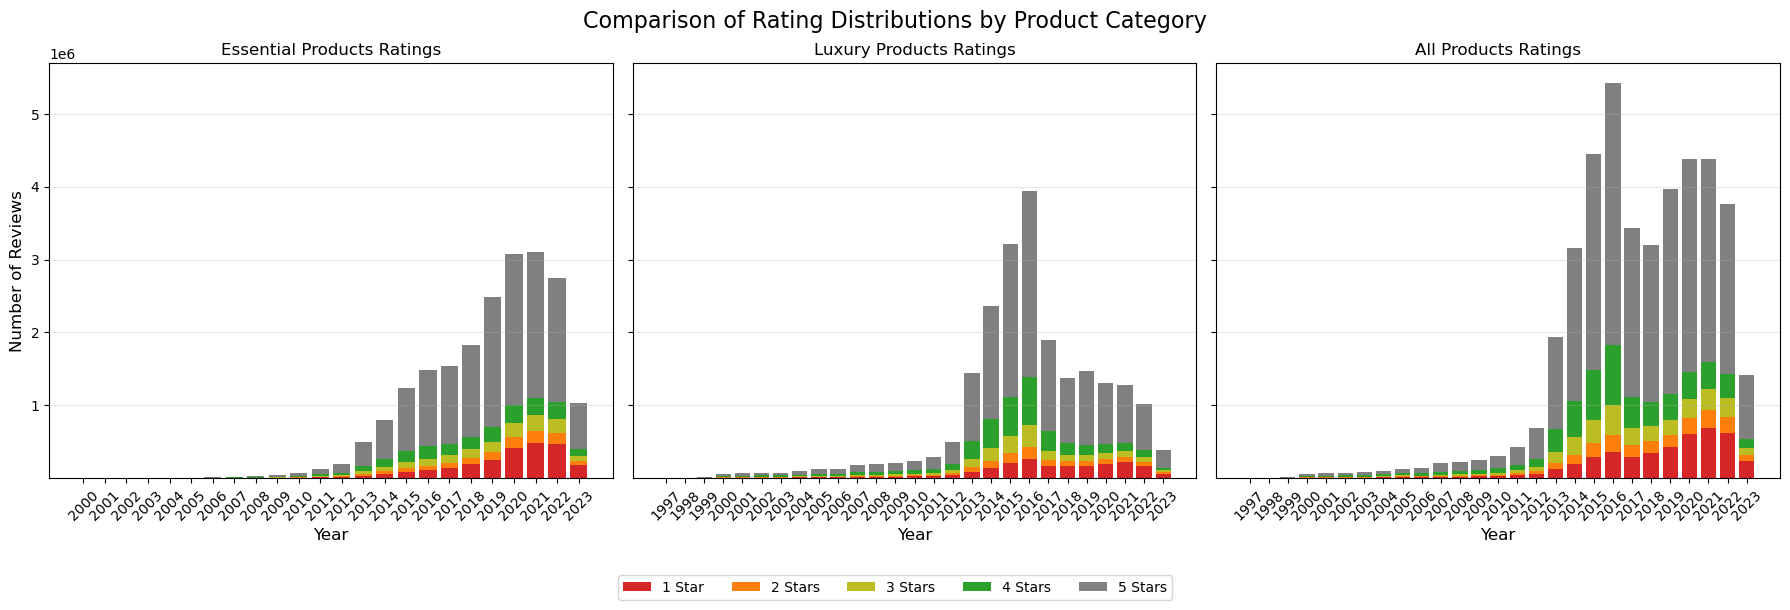

In [24]:
# Review distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plots_data = [
    {"data": results['essential']['rating_data'], "title": "Essential Products", "ax": axes[0]},
    {"data": results['luxury']['rating_data'], "title": "Luxury Products", "ax": axes[1]},
    {"data": results['merged']['rating_data'], "title": "All Products", "ax": axes[2]}]
    
colors = ['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', 'gray']
labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
    
# Create each subplot
for plot in plots_data:
    data = plot["data"]
    ax = plot["ax"]
    title = plot["title"]
        
    years, one_star, two_star, three_star, four_star, five_star = zip(*data)
    bar_width = 0.8
    bottom = [0] * len(years)
    ratings_data = [one_star, two_star, three_star, four_star, five_star]
        
    for i, (rating_data, color, label) in enumerate(zip(ratings_data, colors, labels)):
        if plot == plots_data[0]:
            ax.bar(years, rating_data, bar_width, bottom=bottom, label=label, color=color) # Only add label to the first plot

        else:
            ax.bar(years, rating_data, bar_width, bottom=bottom, color=color)
        bottom = [b + r for b, r in zip(bottom, rating_data)]
        
    ax.set_xlabel('Year', fontsize=12)
    if plot == plots_data[0]:  
        ax.set_ylabel('Number of Reviews', fontsize=12) # Only add y-label to the first subplot
    ax.set_title(f'{title} Ratings', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  
plt.suptitle('Comparison of Rating Distributions by Product Category', fontsize=16)
plt.subplots_adjust(bottom=0.2)  
plt.show()



In [25]:
def calculate_yearly_stats(df, name):
    yearly_avg_ratings = df.groupBy("year").agg(avg("rating").alias("avg_rating"),count("*").alias(
        "review_count")).orderBy("year").cache()
    print(f"\n{name} - Yearly average ratings:")
    yearly_avg_ratings.show(5)
    
    yearly_stats = yearly_avg_ratings.collect()
    years = [row['year'] for row in yearly_stats]
    avg_ratings = [row['avg_rating'] for row in yearly_stats]
    review_counts = [row['review_count'] for row in yearly_stats]
    
    return {'years': years,'avg_ratings': avg_ratings,'review_counts': review_counts,'dataframe': yearly_avg_ratings}

yearly_stats = {}

for name, df in analysis_df.items():
    yearly_stats[name] = calculate_yearly_stats(df, name.capitalize())



Essential - Yearly average ratings:
+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|2000|               4.5|          14|
|2001|3.9166666666666665|         216|
|2002|  3.73921568627451|        1020|
|2003| 3.937731196054254|        1622|
|2004|3.8281951511523498|        3341|
+----+------------------+------------+
only showing top 5 rows


Luxury - Yearly average ratings:
+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|1997|4.7272727272727275|          33|
|1998| 4.410774410774411|        1485|
|1999| 4.258238316000501|       15962|
|2000| 4.129080568382392|       56089|
|2001| 4.064969257449157|       63430|
+----+------------------+------------+
only showing top 5 rows


Merged - Yearly average ratings:
+----+------------------+------------+
|year|        avg_rating|review_count|
+----+------------------+------------+
|1997|4.7272727272727275| 

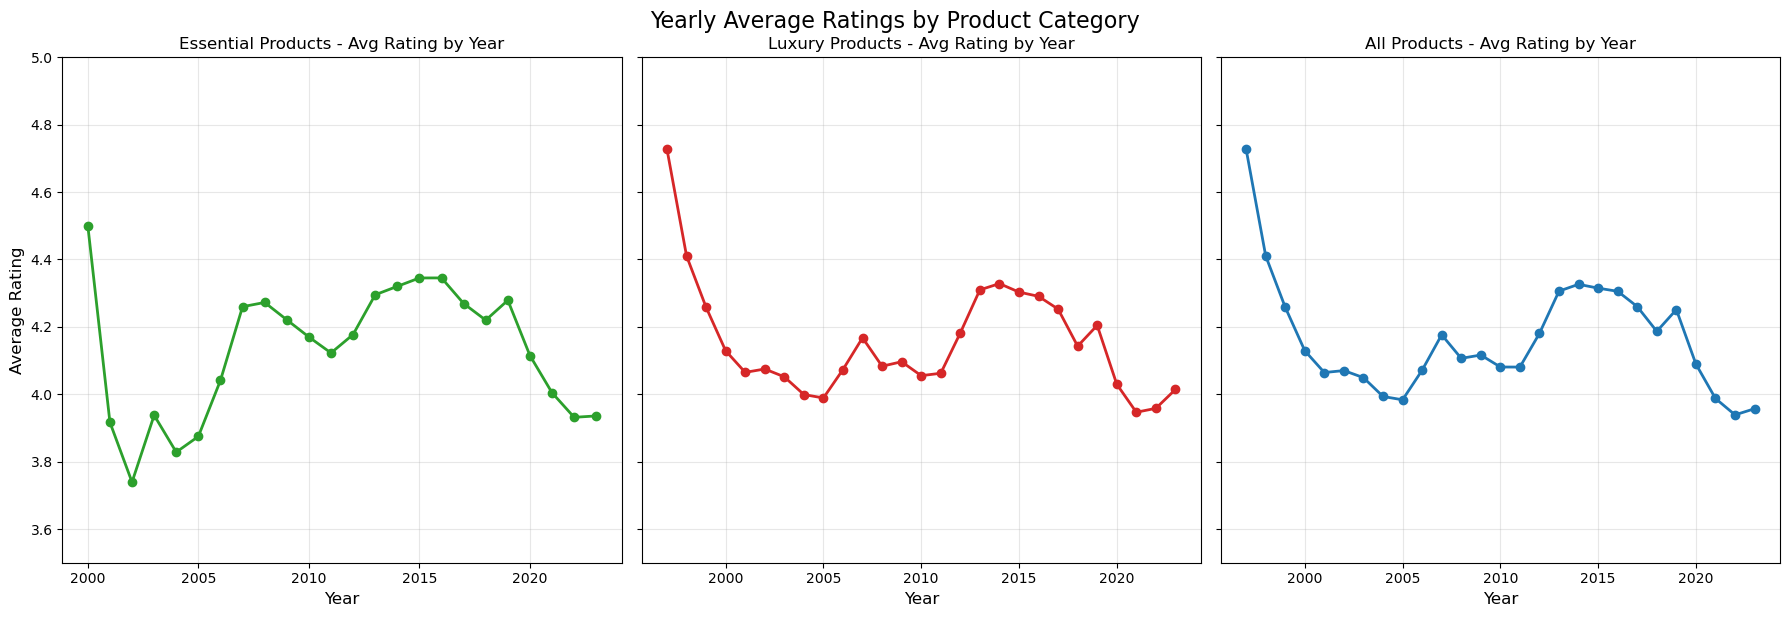

In [27]:
# Yearly average rating plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot essential products
essential_data = yearly_stats['essential']
axes[0].plot(essential_data['years'], essential_data['avg_ratings'], 'o-', color='#2ca02c', linewidth=2)
axes[0].set_title('Essential Products - Avg Rating by Year', fontsize=12)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Average Rating', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(3.5, 5.0)


# Plot luxury products
luxury_data = yearly_stats['luxury']
axes[1].plot(luxury_data['years'], luxury_data['avg_ratings'], 'o-', color='#d62728', linewidth=2)
axes[1].set_title('Luxury Products - Avg Rating by Year', fontsize=12)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(3.5, 5.0)
# Add value lab

# Plot merged products
merged_data = yearly_stats['merged']
axes[2].plot(merged_data['years'], merged_data['avg_ratings'], 'o-', color='#1f77b4', linewidth=2)
axes[2].set_title('All Products - Avg Rating by Year', fontsize=12)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(3.5, 5.0)

plt.tight_layout()
plt.suptitle('Yearly Average Ratings by Product Category', fontsize=16, y=1.02)
plt.show()


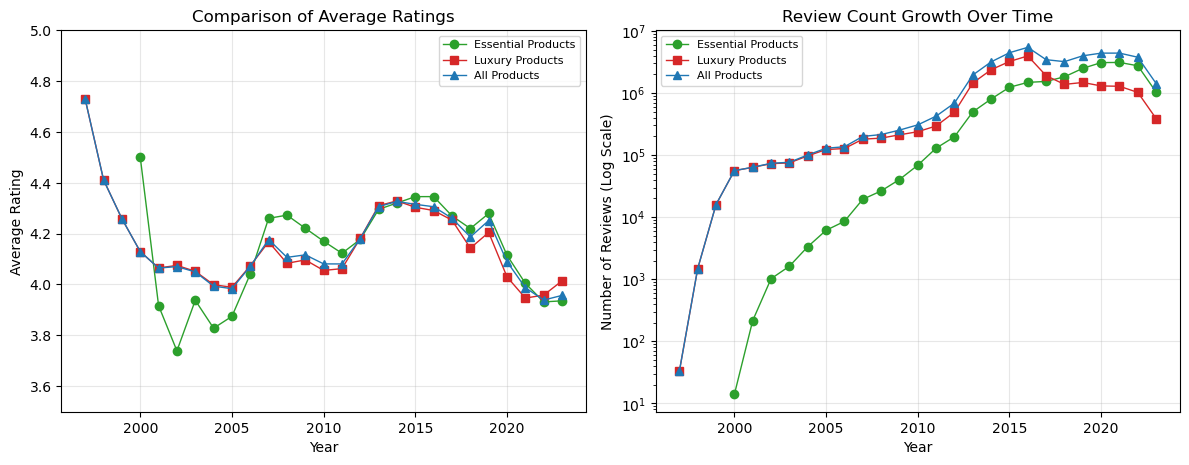

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Combine avg rating plots
ax1.plot(essential_data['years'], essential_data['avg_ratings'], 'o-', color='#2ca02c', linewidth=1, label='Essential Products')
ax1.plot(luxury_data['years'], luxury_data['avg_ratings'], 's-', color='#d62728', linewidth=1, label='Luxury Products')
ax1.plot(merged_data['years'], merged_data['avg_ratings'], '^-', color='#1f77b4', linewidth=1, label='All Products')
ax1.set_title('Comparison of Average Ratings', fontsize=12)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Average Rating', fontsize=10)
ax1.set_ylim(3.5, 5.0)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8)

# Review growth plot
ax2.semilogy(essential_data['years'], essential_data['review_counts'], 'o-', color='#2ca02c', linewidth=1, label='Essential Products')
ax2.semilogy(luxury_data['years'], luxury_data['review_counts'], 's-', color='#d62728', linewidth=1, label='Luxury Products')
ax2.semilogy(merged_data['years'], merged_data['review_counts'], '^-', color='#1f77b4', linewidth=1, label='All Products')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Number of Reviews (Log Scale)', fontsize=10)
ax2.set_title('Review Count Growth Over Time', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()